In [ ]:
# loading the required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind
from itertools import combinations

from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
from google.colab import drive  # to mount Drive to Colab notebook
# Connect Google Drive to Colab
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dataset = pd.read_csv("./gdrive/My Drive/Colab Notebooks/201114COVID19MEXICO.csv", encoding= 'iso-8859-1')

In [ ]:
# Converting date columns to datetime format
dataset['FECHA_INGRESO'] = pd.to_datetime(dataset['FECHA_INGRESO'], errors='coerce')
dataset['FECHA_SINTOMAS'] = pd.to_datetime(dataset['FECHA_SINTOMAS'], errors='coerce')
dataset['FECHA_ACTUALIZACION'] = pd.to_datetime(dataset['FECHA_ACTUALIZACION'], errors='coerce')

In [ ]:
# Adding handcrafted features
dataset['SINTOMAS_INGRESO'] = (dataset['FECHA_INGRESO'] - dataset['FECHA_SINTOMAS']).dt.days

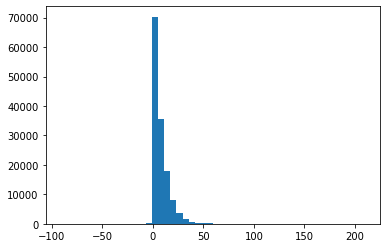

In [ ]:
# Calculating some statistics for the number of dates between ingreso and defuncion
fecha_def = pd.to_datetime(dataset['FECHA_DEF'], errors='coerce')
ingreso_defuncion = (fecha_def - dataset['FECHA_INGRESO']).dt.days
ingreso_defuncion = ingreso_defuncion[pd.notna(ingreso_defuncion)]

# Parameters for a half-normal distribution
sintomas_defuncion_mean = 0
sintomas_defuncion_std= np.sqrt((1 / ingreso_defuncion.shape[0]) * np.sum(ingreso_defuncion ** 2))

# Plot the distribution, as it can be seen it follows a half-normal distribution
plt.hist(ingreso_defuncion, bins=50)
plt.show()

In [ ]:
# Defining a threshold for data considering 2 standard deviations
# The cummulative distribution function of a half normal distribution is given by
cdf_half_norm = 2 * norm.cdf( (sintomas_defuncion_std * 2) / sintomas_defuncion_std) - 1
data_threshold = int(sintomas_defuncion_mean + 2 * sintomas_defuncion_std)
print('Number of days removed from database is: ', data_threshold)
print('Our confidence interval would be: ', np.round(cdf_half_norm * 100, 2), '%')

Number of days removed from database is:  23
Our confidence interval would be:  95.45 %


In [ ]:
# Removing data that we do not know if the outcome was a death or recovery based on a confidence interval.
X = dataset[np.logical_not(np.logical_and(dataset['FECHA_INGRESO'] > (dataset['FECHA_ACTUALIZACION'] - pd.to_timedelta(data_threshold, unit = 'd')),(dataset['FECHA_DEF'] == '9999-99-99')))]
# Filtering out negative tests, just positive tests are left on the dataset
X = X[np.logical_or(np.logical_or(X['CLASIFICACION_FINAL'] == 1, X['CLASIFICACION_FINAL'] == 2), X['CLASIFICACION_FINAL'] == 3)]
# Creating labels based on COVID results
y = 1 * (X['FECHA_DEF'] != '9999-99-99')

In [ ]:
# Deleting not used features
columns_to_drop = ['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ENTIDAD_NAC', 'MUNICIPIO_RES', 'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'TOMA_MUESTRA', 'NACIONALIDAD', 'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'RESULTADO_LAB', 'CLASIFICACION_FINAL']
X = X.drop(columns = columns_to_drop)

In [ ]:
X

,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_RES,TIPO_PACIENTE,INTUBADO,NEUMONIA,EDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,UCI,SINTOMAS_INGRESO
0,2,9,21,2,21,1,97,2,75,97,2,2,1,2,2,2,2,2,1,2,2,2,2,97,6
1,1,4,5,1,5,1,97,2,47,2,2,2,2,2,2,2,2,2,2,2,2,2,1,97,6
2,2,4,9,2,9,2,2,1,58,97,2,2,1,1,2,2,1,2,2,2,1,2,99,1,0
3,1,4,15,2,15,2,2,1,49,97,1,2,2,2,2,2,2,2,2,2,2,2,99,2,0
4,1,12,15,1,15,1,97,2,27,2,2,2,2,2,2,2,2,2,2,2,2,2,1,97,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2604459,2,10,9,2,15,2,2,2,56,97,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2604469,1,6,9,2,15,2,1,1,65,97,2,2,98,98,98,98,98,98,98,98,98,98,2,2,0
2604517,1,12,26,2,26,1,97,2,29,97,2,2,2,2,2,2,2,2,2,2,2,2,1,97,4
2604538,1,6,9,1,15,2,1,1,62,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,7


In [ ]:
# Balancing classes
total_deaths = len(y[y == 1])
recovery_indices = y[y == 0].index
death_indices = np.array(y[y == 1].index)
random_indices = np.random.choice(recovery_indices, total_deaths, replace=False)
final_indices = np.concatenate([random_indices, death_indices])

# Selecting the dataset as per the final_indices
X = X.loc[final_indices]
y = y.loc[final_indices]

In [ ]:
# Splitting dataset in train and test datasets with a proportion of 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

In [ ]:
# Defining wich columns to transform to each transformer
for_standardscaler = ['EDAD', 'SINTOMAS_INGRESO']
for_OneHotEncoder = ['ORIGEN', 'SECTOR', 'ENTIDAD_UM', 'SEXO', 'ENTIDAD_RES', 'TIPO_PACIENTE',
                     'INTUBADO', 'NEUMONIA', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA', 'DIABETES','EPOC', 'ASMA', 'INMUSUPR',
                     'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA',
                     'TABAQUISMO', 'OTRO_CASO', 'UCI']

In [ ]:
# Categories values per column
ORIGEN = np.append(np.arange(1, 3), 99)
SECTOR = np.append(np.arange(1, 14), 99)
ENTIDAD_UM = np.append(np.arange(1, 37), (97, 98, 99))
SEXO = np.append(np.arange(1, 3), 99)
ENTIDAD_RES = np.append(np.arange(1, 37), (97, 98, 99))
TIPO_PACIENTE = np.append(np.arange(1, 3), 99)
INTUBADO = np.append(np.arange(1, 3), (97, 98, 99))
NEUMONIA = np.append(np.arange(1, 3), (97, 98, 99))
EMBARAZO = np.append(np.arange(1, 3), (97, 98, 99))
HABLA_LENGUA_INDIG = np.append(np.arange(1, 3), (97, 98, 99))
INDIGENA = np.append(np.arange(1, 3), (97, 98, 99))
DIABETES = np.append(np.arange(1, 3), (97, 98, 99))
EPOC = np.append(np.arange(1, 3), (97, 98, 99))
ASMA = np.append(np.arange(1, 3), (97, 98, 99))
INMUSUPR = np.append(np.arange(1, 3), (97, 98, 99))
HIPERTENSION = np.append(np.arange(1, 3), (97, 98, 99))
OTRA_COM = np.append(np.arange(1, 3), (97, 98, 99))
CARDIOVASCULAR = np.append(np.arange(1, 3), (97, 98, 99))
OBESIDAD = np.append(np.arange(1, 3), (97, 98, 99))
RENAL_CRONICA = np.append(np.arange(1, 3), (97, 98, 99))
TABAQUISMO = np.append(np.arange(1, 3), (97, 98, 99))
OTRO_CASO = np.append(np.arange(1, 3), (97, 98, 99))
UCI = np.append(np.arange(1, 3), (97, 98, 99))

In [ ]:
# Putting all possible categories into a single list
categories_list = [eval(x) for x in for_OneHotEncoder]

In [ ]:
# Transformer
transformer = ColumnTransformer(transformers=[("scaler", StandardScaler(), for_standardscaler),
                                             ('onehotencoder', OneHotEncoder(categories = categories_list, sparse=False), for_OneHotEncoder)])

In [ ]:
# Transformer2
transformer2 = ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(categories = categories_list, sparse=False), for_OneHotEncoder)], remainder='passthrough')

In [ ]:
# Transforming the data, StandardScaler and OneHotCoder for training and test datasets
transformer.fit(X_train)
X_train_transformed = transformer.transform(X_train)
X_test_transformed = transformer.transform(X_test)

In [ ]:
# Transforming the data, StandardScaler and OneHotCoder for training and test datasets
transformer2.fit(X_train)
X_train_transformed2 = transformer2.transform(X_train)
X_test_transformed2 = transformer2.transform(X_test)

# **Decision Tree**

In [ ]:
import graphviz
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [ ]:
# Getting feature names after transformation
feature_name_list = ['EDAD','SINTOMAS_INGRESO']

for feature in range(len(for_OneHotEncoder)):
  for subfeature in range(len(eval(for_OneHotEncoder[feature]))):
    feature_name_list.append(for_OneHotEncoder[feature] + '_' + str(categories_list[feature][subfeature]))

In [ ]:
feature_name_list = [ 'EDAD',
 'SINTOMAS_INGRESO',
 'ORIGEN_1',
 'ORIGEN_2',
 'ORIGEN_99',
 'SECTOR_1',
 'SECTOR_2',
 'SECTOR_3',
 'SECTOR_4',
 'SECTOR_5',
 'SECTOR_6',
 'SECTOR_7',
 'SECTOR_8',
 'SECTOR_9',
 'SECTOR_10',
 'SECTOR_11',
 'SECTOR_12',
 'SECTOR_13',
 'SECTOR_99',
 'ENTIDAD_UM_1',
 'ENTIDAD_UM_2',
 'ENTIDAD_UM_3',
 'ENTIDAD_UM_4',
 'ENTIDAD_UM_5',
 'ENTIDAD_UM_6',
 'ENTIDAD_UM_7',
 'ENTIDAD_UM_8',
 'ENTIDAD_UM_9',
 'ENTIDAD_UM_10',
 'ENTIDAD_UM_11',
 'ENTIDAD_UM_12',
 'ENTIDAD_UM_13',
 'ENTIDAD_UM_14',
 'ENTIDAD_UM_15',
 'ENTIDAD_UM_16',
 'ENTIDAD_UM_17',
 'ENTIDAD_UM_18',
 'ENTIDAD_UM_19',
 'ENTIDAD_UM_20',
 'ENTIDAD_UM_21',
 'ENTIDAD_UM_22',
 'ENTIDAD_UM_23',
 'ENTIDAD_UM_24',
 'ENTIDAD_UM_25',
 'ENTIDAD_UM_26',
 'ENTIDAD_UM_27',
 'ENTIDAD_UM_28',
 'ENTIDAD_UM_29',
 'ENTIDAD_UM_30',
 'ENTIDAD_UM_31',
 'ENTIDAD_UM_32',
 'ENTIDAD_UM_33',
 'ENTIDAD_UM_34',
 'ENTIDAD_UM_35',
 'ENTIDAD_UM_36',
 'ENTIDAD_UM_97',
 'ENTIDAD_UM_98',
 'ENTIDAD_UM_99',
 'SEXO_1',
 'SEXO_2',
 'SEXO_99',
 'ENTIDAD_RES_1',
 'ENTIDAD_RES_2',
 'ENTIDAD_RES_3',
 'ENTIDAD_RES_4',
 'ENTIDAD_RES_5',
 'ENTIDAD_RES_6',
 'ENTIDAD_RES_7',
 'ENTIDAD_RES_8',
 'ENTIDAD_RES_9',
 'ENTIDAD_RES_10',
 'ENTIDAD_RES_11',
 'ENTIDAD_RES_12',
 'ENTIDAD_RES_13',
 'ENTIDAD_RES_14',
 'ENTIDAD_RES_15',
 'ENTIDAD_RES_16',
 'ENTIDAD_RES_17',
 'ENTIDAD_RES_18',
 'ENTIDAD_RES_19',
 'ENTIDAD_RES_20',
 'ENTIDAD_RES_21',
 'ENTIDAD_RES_22',
 'ENTIDAD_RES_23',
 'ENTIDAD_RES_24',
 'ENTIDAD_RES_25',
 'ENTIDAD_RES_26',
 'ENTIDAD_RES_27',
 'ENTIDAD_RES_28',
 'ENTIDAD_RES_29',
 'ENTIDAD_RES_30',
 'ENTIDAD_RES_31',
 'ENTIDAD_RES_32',
 'ENTIDAD_RES_33',
 'ENTIDAD_RES_34',
 'ENTIDAD_RES_35',
 'ENTIDAD_RES_36',
 'ENTIDAD_RES_97',
 'ENTIDAD_RES_98',
 'ENTIDAD_RES_99',
 'Ambulatorio',
 'Hospitalizado',
 'TIPO_PACIENTE_99',
 'INTUBADO_1',
 'No fue intubado',
 'INTUBADO_97',
 'INTUBADO_98',
 'INTUBADO_99',
 'Tiene neumonia',
 'No tiene neumonia',
 'NEUMONIA_97',
 'NEUMONIA_98',
 'NEUMONIA_99',
 'EMBARAZO_1',
 'EMBARAZO_2',
 'EMBARAZO_97',
 'EMBARAZO_98',
 'EMBARAZO_99',
 'HABLA_LENGUA_INDIG_1',
 'HABLA_LENGUA_INDIG_2',
 'HABLA_LENGUA_INDIG_97',
 'HABLA_LENGUA_INDIG_98',
 'HABLA_LENGUA_INDIG_99',
 'INDIGENA_1',
 'INDIGENA_2',
 'INDIGENA_97',
 'INDIGENA_98',
 'INDIGENA_99',
 'DIABETES_1',
 'DIABETES_2',
 'DIABETES_97',
 'DIABETES_98',
 'DIABETES_99',
 'EPOC_1',
 'EPOC_2',
 'EPOC_97',
 'EPOC_98',
 'EPOC_99',
 'ASMA_1',
 'ASMA_2',
 'ASMA_97',
 'ASMA_98',
 'ASMA_99',
 'INMUSUPR_1',
 'INMUSUPR_2',
 'INMUSUPR_97',
 'INMUSUPR_98',
 'INMUSUPR_99',
 'HIPERTENSION_1',
 'HIPERTENSION_2',
 'HIPERTENSION_97',
 'HIPERTENSION_98',
 'HIPERTENSION_99',
 'OTRA_COM_1',
 'OTRA_COM_2',
 'OTRA_COM_97',
 'OTRA_COM_98',
 'OTRA_COM_99',
 'CARDIOVASCULAR_1',
 'CARDIOVASCULAR_2',
 'CARDIOVASCULAR_97',
 'CARDIOVASCULAR_98',
 'CARDIOVASCULAR_99',
 'OBESIDAD_1',
 'OBESIDAD_2',
 'OBESIDAD_97',
 'OBESIDAD_98',
 'OBESIDAD_99',
 'RENAL_CRONICA_1',
 'RENAL_CRONICA_2',
 'RENAL_CRONICA_97',
 'RENAL_CRONICA_98',
 'RENAL_CRONICA_99',
 'TABAQUISMO_1',
 'TABAQUISMO_2',
 'TABAQUISMO_97',
 'TABAQUISMO_98',
 'TABAQUISMO_99',
 'OTRO_CASO_1',
 'OTRO_CASO_2',
 'OTRO_CASO_97',
 'OTRO_CASO_98',
 'Se desconoce si tuvo contacto',
 'UCI_1',
 'UCI_2',
 'Cuidados intensivos ',
 'UCI_98',
 'UCI_99'
 ]

In [ ]:
scaler2 = StandardScaler()
scaler2.fit(np.reshape(X_train['EDAD'].values,(-1,1)))
print(scaler2.var_)
print(scaler2.mean_)

[328.13141492]
[52.51287419]


In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=3, splitter='best')
clf = clf.fit(X_train_transformed, y_train)

Accuracy on train set: 0.8898096858143965
Accuracy on test set: 0.8904267589388697
              precision    recall  f1-score   support

   Defuncion       0.94      0.84      0.88     29478
Recuperacion       0.85      0.94      0.90     29478

    accuracy                           0.89     58956
   macro avg       0.90      0.89      0.89     58956
weighted avg       0.90      0.89      0.89     58956



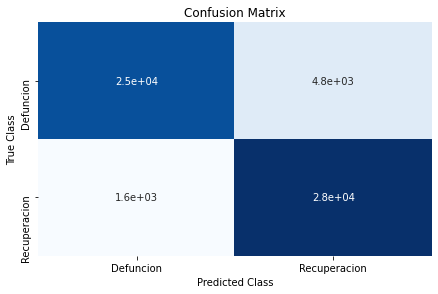

In [ ]:
print('Accuracy on train set: ' + str(clf.score(X_train_transformed, y_train)))
print('Accuracy on test set: ' + str(clf.score(X_test_transformed, y_test)))
# Create list of target class names
class_names = ['Defuncion', 'Recuperacion']
target_predicted = clf.predict(X_test_transformed)
print(classification_report(y_test,
      target_predicted,
      target_names=class_names))
# Create confusion matrix
cmatrix = confusion_matrix(y_test, target_predicted)
# Create pandas dataframe
dataframe = pd.DataFrame(cmatrix, index=class_names, columns=class_names)
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

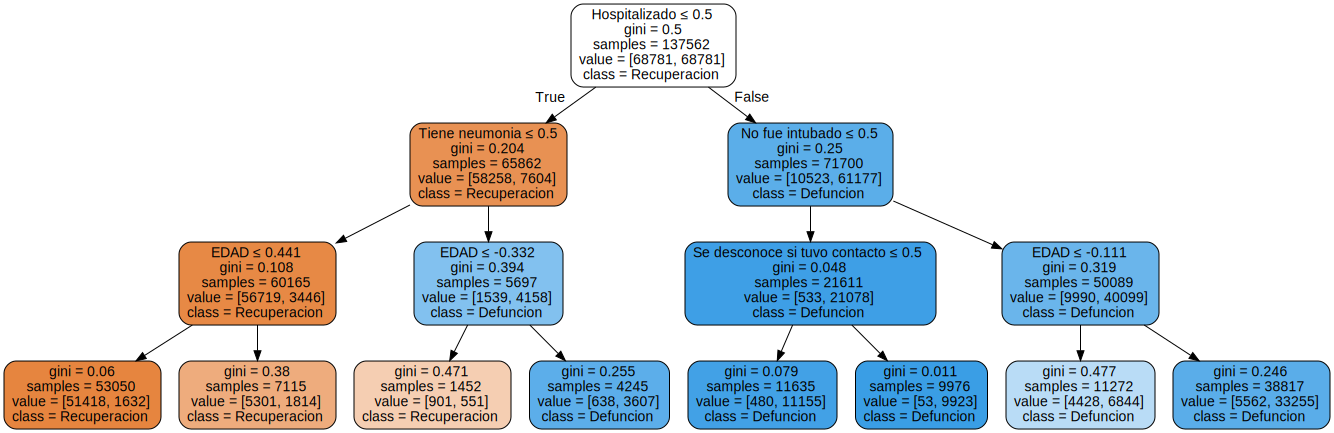

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names = feature_name_list,
                                class_names = ['Recuperacion', 'Defuncion'],
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

# **Neural Network MLP**

In [ ]:
number_of_features = X_train_transformed.shape[1]
# Create function returning a compiled network
def create_network(optimizer="rmsprop"):
    # Start neural network
    network = models.Sequential()
    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=16,
                            activation="relu",
                            input_shape=(number_of_features,)))
    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=16, activation="relu"))
    # Add fully connected layer with a softmax activation function
    network.add(layers.Dense(units=1, activation="sigmoid"))
    # Compile neural network
    network.compile(loss="binary_crossentropy", # Cross-entropy
                    optimizer="rmsprop", # Root Mean Square Propagation
                    metrics=["accuracy"]) # Accuracy performance metric
    return network

In [ ]:
def mlprandomsearch(X_train, y_train, hyperparameters, cv, n_iter):
    # Wrap Keras model so it can be used by scikit-learn
    neural_network = KerasClassifier(build_fn=create_network, verbose=0)
    # # Create grid search
    randomsearch = RandomizedSearchCV(estimator=neural_network, param_distributions=hyperparameters, cv=cv, verbose=3, n_iter=n_iter)
    # # Fit grid search
    randomsearch.fit(X_train, y_train)
    return randomsearch, randomsearch.best_estimator_

In [ ]:
# Create hyperparameter space
epochs = [5, 8, 10, 15, 20]
batches = [10, 50, 100, 200, 400]
optimizers = ["rmsprop", "adam"]
# Create hyperparameter options
hyperparameters = dict(optimizer=optimizers, epochs=epochs, batch_size=batches)
number_of_features = X_train_transformed.shape[1]

random_search_mlp, best_mlp = mlprandomsearch(X_train_transformed, y_train, hyperparameters, 5, 10)
# View hyperparameters of best neural network
print(best_mlp)

In [ ]:
# Best parameters found in RandomSearchCV {'optimizer': 'adam', 'epochs': 15, 'batch_size': 100}
# Evaluation
print(random_search_mlp.best_params_)
print(best_mlp.score(X_test_transformed, y_test))
y_predicted = best_mlp.predict(X_test_transformed)
target_names = ['Recuperacion', 'Defuncion']
confusion = confusion_matrix(y_test, y_predicted)
print(classification_report(y_test, y_predicted, target_names = target_names))

In [ ]:
network_ran = create_network(optimizer='adam')
history_ran = network_ran.fit(X_train_transformed, # Features
                        y_train, # Target vector
                        epochs=15, # Number of epochs
                        verbose=3, # Print description after each epoch
                        batch_size=100, # Number of observations per batch
                        validation_data=(X_test_transformed, y_test)) # Test data

y_predicted = network_ran.predict_classes(X_test_transformed)
target_names = ['Recuperacion', 'Defuncion']
confusion = confusion_matrix(y_test, y_predicted)
print(classification_report(y_test, y_predicted, target_names = target_names))

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

Recuperacion       0.94      0.87      0.90     29478
   Defuncion       0.88      0.94      0.91     29478

    accuracy                           0.90     58956
   macro avg       0.91      0.90      0.90     58956
weighted avg       0.91      0.90      0.90     58956



In [ ]:
network_ran.evaluate(X_test_transformed, y_test)

1843/1843 [==============================] - 3s 2ms/step - loss: 0.2451 - accuracy: 0.9044


[0.24508190155029297, 0.9043693542480469]

# **SVM Poly**

In [ ]:
#PCA
# select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.
pca = PCA(n_components = 0.99)
# fit PCA model COVID data
pca.fit(X_train_transformed)
# transform data onto the selected principal components
X_pca = pca.transform(X_train_transformed)
X_test_pca = pca.transform(X_test_transformed)

print("Original shape: {}".format(str(X_train_transformed.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (137562, 188)
Reduced shape: (137562, 59)


In [ ]:
#SVM Polynomial and Random search

def poly_randomsearch(X,y,nfolds,xtest,ytest):
    # defining the random parameter range 
    Cs_rand = np.arange(0.001, 3, 0.001)
    degrees_rand = np.arange(2, 3)
    coefs_rand = np.arange(1, 31)
    param_rand = {'C':Cs_rand,'degree':degrees_rand,'coef0':coefs_rand}

    rand_search_svmpoly = RandomizedSearchCV(SVC(kernel='poly', gamma='auto', max_iter=30000), param_rand, cv=nfolds, refit = True, verbose = 3)

    # # fitting the model for random search
    rand_search_svmpoly.fit(X, y) 

    print ('On training', rand_search_svmpoly.score(X, y))
    print ('On testing', rand_search_svmpoly.score(xtest, ytest))
    print (rand_search_svmpoly.best_params_)
    return rand_search_svmpoly.best_estimator_

In [ ]:
best_svmpoly = poly_randomsearch(X_pca, y_train, 5, X_test_pca, y_test)

In [ ]:
# Best found params = {'degree': 2, 'coef0': 15, 'C': 1.51}
print(best_svmpoly.score(X_test_pca, y_test))
target_names = ['Recuperacion', 'Defuncion']
y_pred = best_svmpoly.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
svm_pca = SVC(kernel="poly", degree=2, coef0=15, C=1.51, random_state=0, verbose=3)
svm_pca.fit(X_pca, y_train)
print(svm_pca.score(X_test_pca, y_test))
target_names = ['Recuperacion', 'Defuncion']
y_pred = svm_pca.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=target_names))

[LibSVM]0.899467399416514
              precision    recall  f1-score   support

Recuperacion       0.94      0.85      0.89     29478
   Defuncion       0.86      0.95      0.90     29478

    accuracy                           0.90     58956
   macro avg       0.90      0.90      0.90     58956
weighted avg       0.90      0.90      0.90     58956



# **SVM Linear**

In [ ]:
#Function to find the best hyperparameters of the model
def get_best_params(X,y,nfolds,xtest,ytest):
    # defining parameter range 
    param_grid = {'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 100, 1000],  
              'loss': ['hinge', 'squared_hinge']}  
  
    grid_search = GridSearchCV(LinearSVC(max_iter=30000), param_grid, cv=nfolds, refit = True, verbose = 3)
    # fitting the model for grid search 
    grid_search.fit(X, y) 
    
#printing Errors on both partitions and also the best parameters
    print ('On training',grid_search.score(X,y))
    print ('On testing', grid_search.score(xtest,ytest))
    print (grid_search.best_params_)
    return grid_search.best_estimator_

In [ ]:
best = get_best_params(X_train_transformed, y_train, 5, X_test_transformed, y_test)

In [ ]:
print(best)
print(best.score(X_test_transformed, y_test))
# Best params found in GridSearchCV = {'C': 1, 'loss': 'hinge'}
target_names = ['Recuperacion', 'Defuncion']
y_pred = best.predict(X_test_transformed)
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
svm_linear = LinearSVC(C=1, loss='hinge', verbose=3)
svm_linear.fit(X_train_transformed, y_train)
print(svm_linear.score(X_test_transformed, y_test))
target_names = ['Recuperacion', 'Defuncion']
y_pred = svm_linear.predict(X_test_transformed)
print(classification_report(y_test, y_pred, target_names=target_names))

[LibLinear]0.8946841712463532
              precision    recall  f1-score   support

Recuperacion       0.92      0.86      0.89     29478
   Defuncion       0.87      0.93      0.90     29478

    accuracy                           0.89     58956
   macro avg       0.90      0.89      0.89     58956
weighted avg       0.90      0.89      0.89     58956



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# **Random Forest**

In [ ]:
# Hyperparameter space
parameters_grid = {
    'n_estimators': np.arange(100, 300, 10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 3, 5, 10, 15],
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [5, 10, 25, 50]
}

In [ ]:
# Randomized search
random_search = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1), param_distributions=parameters_grid, n_iter=10, cv=5, refit=True)
random_search.fit(X_train_transformed, y_train)

KeyboardInterrupt: ignored

In [ ]:
# Print the best parameters found
print(random_search.best_params_)

{'n_estimators': 120, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': None}


In [ ]:
# Evaluating the model on the test set and printing accuracy and classification report
y_pred = random_search.predict(X_test_transformed)
target_names = ['Recuperacion', 'Defuncion']
print(random_search.score(X_test_transformed, y_test))
print(classification_report(y_test, y_pred, target_names=target_names))

0.9024357147703372
              precision    recall  f1-score   support

Recuperacion       0.95      0.85      0.90     29478
   Defuncion       0.87      0.95      0.91     29478

    accuracy                           0.90     58956
   macro avg       0.91      0.90      0.90     58956
weighted avg       0.91      0.90      0.90     58956



# **Statistical Tests**

In [ ]:
# MLP model is compared with a Random Guess Classifier
# Start neural network
network = models.Sequential()
# Add fully connected layer with a ReLU activation function
network.add(layers.Dense(units=16,
                        activation="relu",
                        input_shape=(number_of_features,)))
# Add fully connected layer with a ReLU activation function
network.add(layers.Dense(units=16, activation="relu"))
# Add fully connected layer with a softmax activation function
network.add(layers.Dense(units=1, activation="sigmoid"))
# Compile neural network
network.compile(loss="binary_crossentropy", # Cross-entropy
                optimizer="adam", # Root Mean Square Propagation
                metrics=["accuracy"]) # Accuracy performance metric

In [ ]:
# Training the neural network
network.fit(X_train_transformed, y_train, epochs=15, batch_size=100, verbose=0)

In [ ]:
# Paired t-test
y_test_paired = np.array(y_test)
np.random.seed = 0
N = 1000
sample_size = 30
random_classifier_scores = np.zeros(N)
mlp_classifier_scores = np.zeros(N)
diff = np.zeros(N)

# Getting the samples
for i in range(N):
  sample_indices = np.random.choice(len(X_test_transformed),size=sample_size, replace=False)
  sample_i = X_test_transformed[sample_indices]
  y_i = y_test_paired[sample_indices]
  mlp_classifier_scores[i] = network.evaluate(sample_i, y_i, verbose=0)[1]
  # Random Guess Classifier
  y_pred_random = []
  for j in range(sample_size):
    y_pred_random.append(np.random.choice([0,1],p=[0.5, 0.5]))
  random_classifier_scores[i] = accuracy_score(y_i, y_pred_random)
  diff[i] = mlp_classifier_scores[i] - random_classifier_scores[i]

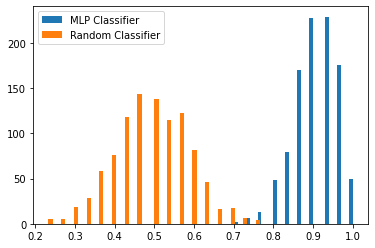

In [ ]:
# Plotting distributions
plt.hist(mlp_classifier_scores, 30)
plt.hist(random_classifier_scores, 50)
plt.legend(['MLP Classifier', 'Random Classifier'])
plt.show()

In [ ]:
# Sample mean and Sample standard deviation
m = np.mean(diff)
S = np.std(diff, ddof=1)

In [ ]:
# t-statistic and p-value
t_statistic = (np.sqrt(N) * m) / S
p_value = (1 - t.cdf(t_statistic, N-1))* 2

In [ ]:
# With a p value less than alpha=0.05 then we reject the null hypothesis of equal means
ttest_ind(mlp_classifier_scores, random_classifier_scores)

Ttest_indResult(statistic=121.34496342302762, pvalue=0.0)

In [ ]:
# Random Forest
best_parameters = {'n_estimators': 120, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': None}
random_forest = RandomForestClassifier(n_jobs=-1, **best_parameters)
random_forest.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
# All vs All
def significance_t_test(classifiers, number_of_samples, sample_size, alpha):
  X_t_test = np.copy(X_test_transformed)
  X_t_test_pca = np.copy(X_test_pca)
  y_t_test = np.copy(y_test)
  N = number_of_samples
    
  classifiers_str = dict(zip(combinations([eval(x) for x in classifiers], 2), combinations(classifiers, 2)))
  classifiers = [eval(x) for x in classifiers]

  clf_scores = {clf: np.zeros(N) for clf in classifiers}
  differences = {clfs: np.zeros(N) for clfs in combinations(classifiers, 2)}
  results = {classifiers_str[clfs]: None for clfs in combinations(classifiers, 2)}

  for i in range(N):
    sample_indices = np.random.choice(len(X_t_test),size=sample_size, replace=False)
    sample_i = X_t_test[sample_indices]
    y_i = y_t_test[sample_indices]

    # Testing on the sample
    for clf in classifiers:
      if clf == network:
        clf_scores[clf][i] = clf.evaluate(sample_i, y_i, verbose=0)[1]
      elif clf == svm_pca:
        sample_i_pca = X_t_test_pca[sample_indices]
        clf_scores[clf][i] = clf.score(sample_i_pca, y_i)
      else:
        clf_scores[clf][i] = clf.score(sample_i, y_i)
      
    # Removing used examples
    X_t_test = np.delete(X_t_test, sample_indices, 0)
    X_t_test_pca = np.delete(X_t_test_pca, sample_indices, 0)
    y_t_test = np.delete(y_t_test, sample_indices, 0)

  for clfs in combinations(classifiers, 2):
    differences[clfs] = clf_scores[clfs[0]] - clf_scores[clfs[1]]
    m = np.mean(differences[clfs])
    S = np.std(differences[clfs], ddof=1)
    t_statistic = (np.sqrt(N) * m) / S
    p_value = (1 - t.cdf(t_statistic, N-1))* 2

    if p_value > alpha:
      results[classifiers_str[clfs]] = 'H0 accepted' # H0: Equal means
    else:
      results[classifiers_str[clfs]] = 'H0 rejected' # H0: Equal means
  return differences, results

In [ ]:
# Testing sifnificance difference between classifiers
list_of_classifiers = ['network', 'svm_linear', 'svm_pca', 'random_forest']
differences, results = significance_t_test(classifiers=list_of_classifiers, number_of_samples=1000, sample_size=30, alpha=0.05)

In [ ]:
results

{('network', 'random_forest'): 'H0 rejected',
 ('network', 'svm_linear'): 'H0 rejected',
 ('network', 'svm_pca'): 'H0 rejected',
 ('svm_linear', 'random_forest'): 'H0 accepted',
 ('svm_linear', 'svm_pca'): 'H0 accepted',
 ('svm_pca', 'random_forest'): 'H0 accepted'}